In [1]:
import torch
import IPython
import torch.utils
import torch.distributions
import torchvision
import math
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn

In [2]:
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [15]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.to_mean_logvar = nn.Linear(512, 2*latent_dims)
        
    def reparametrization_trick(self, mu, log_var):
        # Using reparameterization trick to sample from a gaussian
        eps = torch.randn_like(log_var)
        return mu + torch.exp(log_var / 2) * eps
    
    def forward(self, x, params = False):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
        self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        if params == True:
          return mu, log_var
        
        return self.reparametrization_trick(mu, log_var)

In [19]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [20]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)        
        return self.decoder(z)

In [21]:
def train(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
            loss.backward()
            opt.step()
    return vae

In [22]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [23]:
def plot_reconstructed(autoencoder,  r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = []
    for i, z2 in enumerate(np.linspace(r1[1],r1[0], n)):
        for j, z1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[z1, z2]]).to(device)
            x_hat = autoencoder.decoder(z)
            img.append(x_hat)
            
    img = torch.cat(img)
    img = torchvision.utils.make_grid(img,nrow=12).permute(1, 2, 0).detach().numpy()
    plt.imshow(img,extent=[*r0, *r1])

In [24]:
z_dim = 2

vae = VariationalAutoencoder(z_dim).to(device) # GPU
vae = train(vae, data_loader, epochs=20)

In [25]:
x, y = data_loader.__iter__().next()

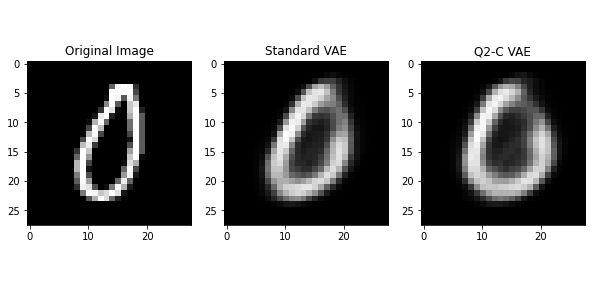

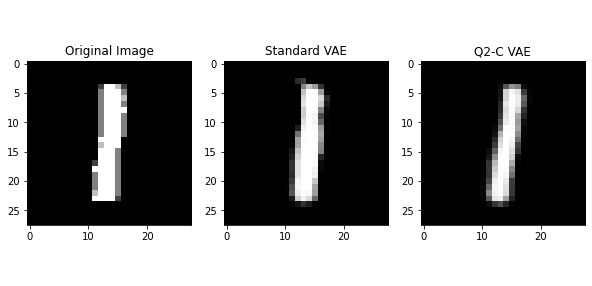

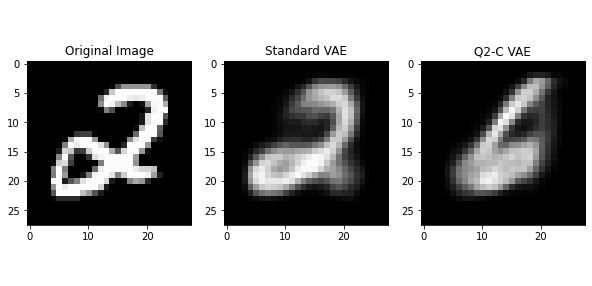

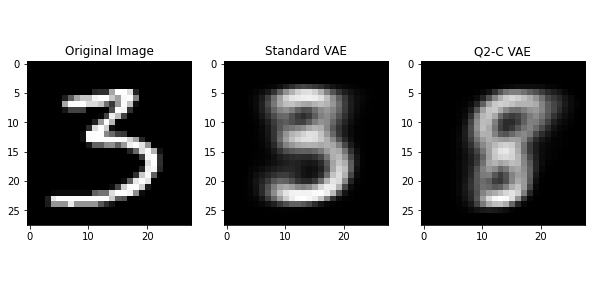

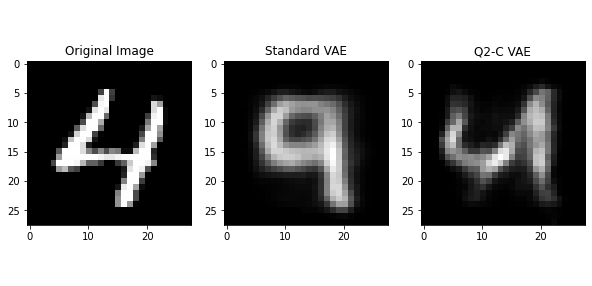

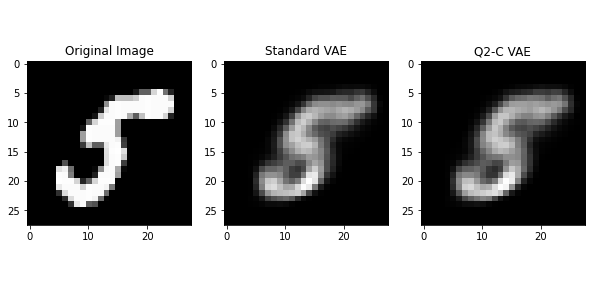

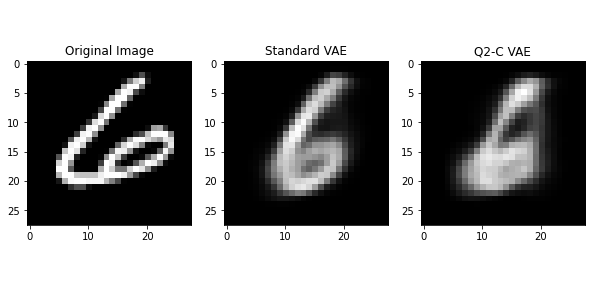

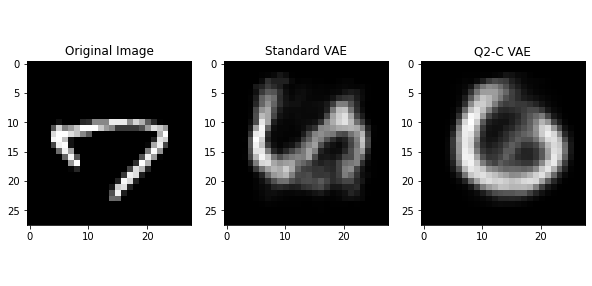

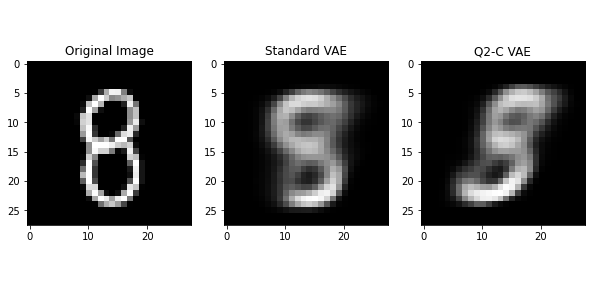

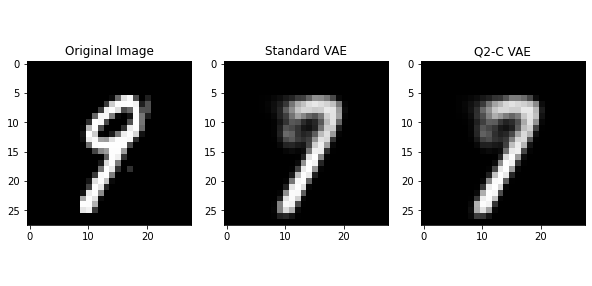

In [26]:
for i in range(10):
  for x, y in data_loader:
    for k, ylabel in enumerate(y):
      if ylabel == i:                                         #Pick a sample x from the dataset
        
        x = x[k].to(device) 

        mu, log_var = vae.encoder.forward(x,True)            #Encode
         
        mu12 = [float(mu[0][0]),float(mu[0][1])]
       

        std12 = [math.exp(log_var[0][0] /2),math.exp(log_var[0][1] /2)]
        
        eps12 = [np.random.uniform(-1, 1),np.random.uniform(-1, 1)]                       #Sample some noise
                             #Sample some noise

        lat12 = [np.random.normal(mu12[0] +eps12[0], std12[0]), np.random.normal(mu12[1] +eps12[1], std12[1])]             #Sample latent varialbles
                  #Sample latent varialbles
        x_Q2C = vae.decoder(torch.Tensor([lat12[0],lat12[1]]))        #Decode the latent variables
        x_standard = vae.forward(x)

        Q2C_vae_img = x_Q2C.detach().numpy().squeeze()
        standard_vae_img = x_standard.detach().numpy().squeeze()
        
        fig = plt.figure(figsize=(10, 5))
        plt.axis('off')
        ax1 = fig.add_subplot(1,3,1)
        ax1.title.set_text("Original Image")
        ax1.imshow(x.squeeze(), cmap='''gray''')

        ax2 = fig.add_subplot(1,3,2)
        ax2.title.set_text("Standard VAE")
        ax2.imshow(standard_vae_img, cmap='''gray''')

        ax3 = fig.add_subplot(1,3,3)
        ax3.title.set_text("Q2-C VAE")
        ax3.imshow(Q2C_vae_img, cmap='''gray''')

        break
    break

          

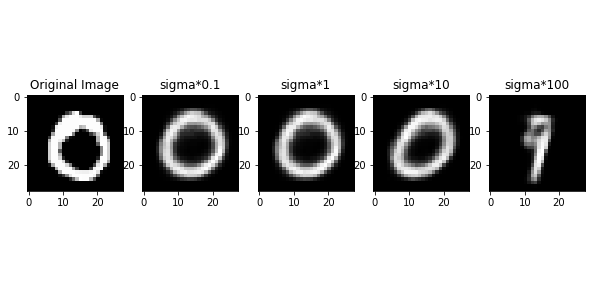

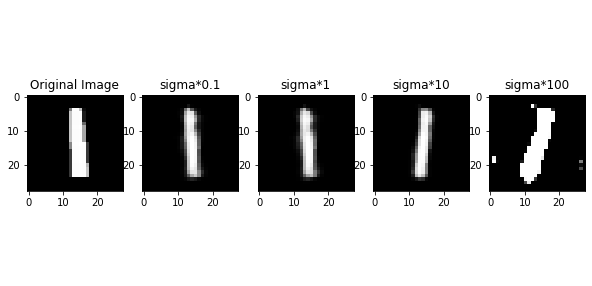

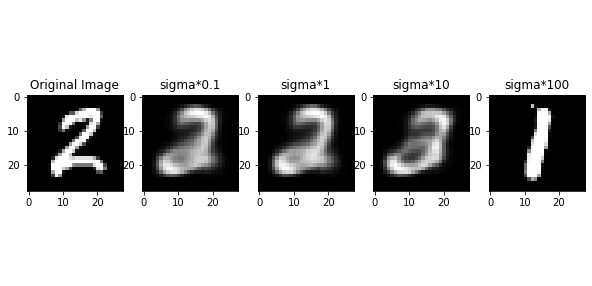

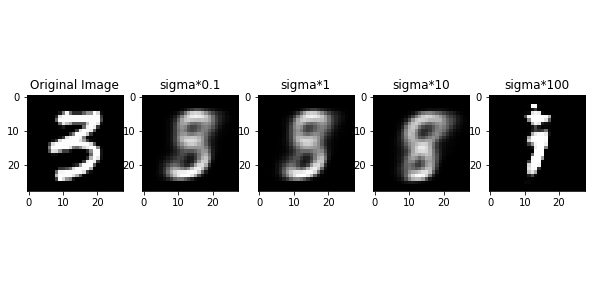

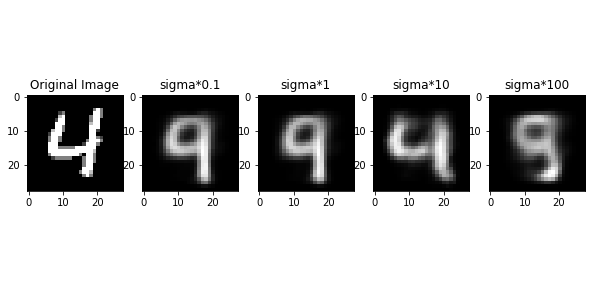

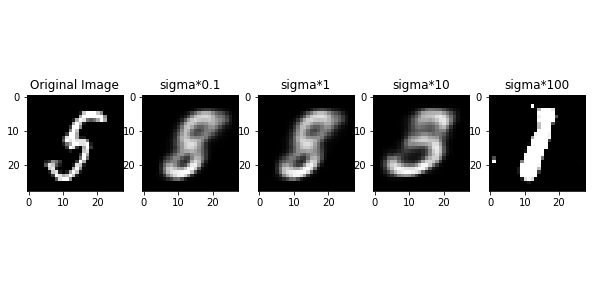

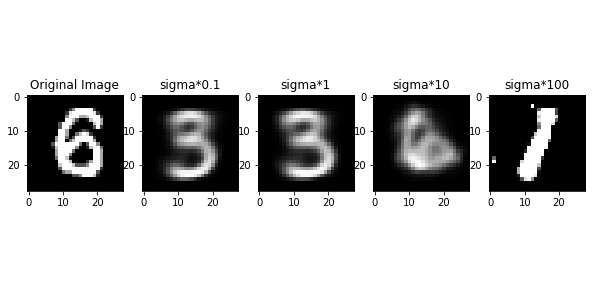

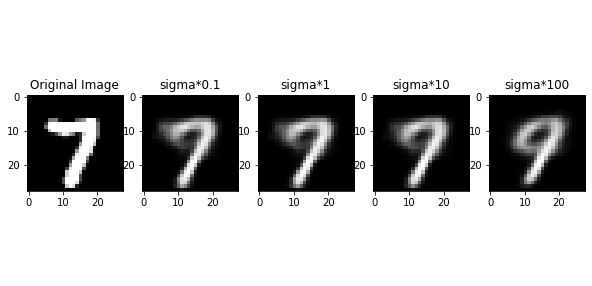

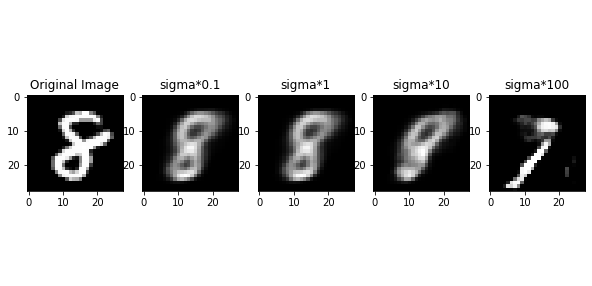

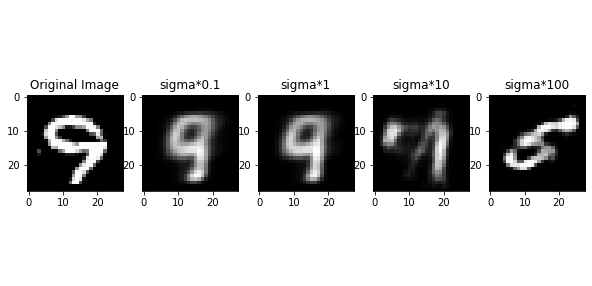

In [29]:
for i in range(10):
  for x, y in data_loader:
    for k, ylabel in enumerate(y):
      if ylabel == i:
        
        x = x[k].to(device)

        mu, log_var = vae.encoder.forward(x, True)
        
        mu12=  [float(mu[0][0]),float(mu[0][1])]
        

        std12 = (math.exp(log_var[0][0] /2),math.exp(log_var[0][1] /2))
      

        images = []

        fig = plt.figure(figsize=(10, 5))
        plt.axis('off')

        ax1 = fig.add_subplot(1,5,1)
        ax1.title.set_text("Original Image")
        ax1.imshow(x.squeeze(), cmap='''gray''')


        mul = [0.1, 1, 10, 100]
        for i, mul in enumerate(mul):
          lat1 = np.random.normal(mu12[0] +eps12[0], std12[0]*mul)
          lat2 = np.random.normal(mu12[1] +eps12[1], std12[1]*mul)
          x_Q2D = vae.decoder(torch.Tensor([lat1,lat2]))
          Q2D_vae_img = x_Q2D.detach().numpy().squeeze()


          ax2 = fig.add_subplot(1,5,i+2)
          ax2.title.set_text(f"sigma*{mul}")
          ax2.imshow(Q2D_vae_img, cmap='''gray''')



        break
    break

          

In [30]:
def train_recon_part(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            loss.backward()
            opt.step()
    return vae

In [31]:
def train_kl_part(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss =vae.encoder.kl
            loss.backward()
            opt.step()
    return vae

In [32]:
standard_vae_kl = VariationalAutoencoder(z_dim).to(device) # GPU
standard_vae_kl = train_kl_part(standard_vae_kl, data_loader, epochs=20)

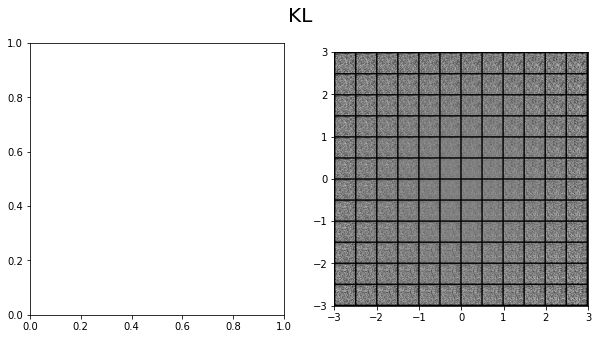

In [33]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("KL", fontsize = 20)
ax1 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
ax1 = plot_reconstructed(standard_vae_kl, r0=(-3, 3), r1=(-3, 3))

In [35]:
standard_vae_recon = VariationalAutoencoder(z_dim).to(device) # GPU
standard_vae_recon = train_recon_part(standard_vae_recon, data_loader, epochs=20)

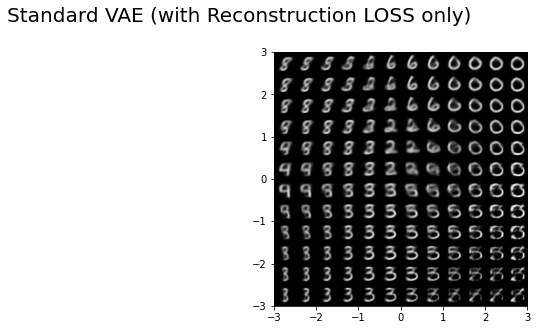

In [37]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Standard VAE (with Reconstruction LOSS only)", fontsize = 20)
ax1 = fig.add_subplot(1,2,2)
ax1 = plot_reconstructed(standard_vae_recon, r0=(-3, 3), r1=(-3, 3))



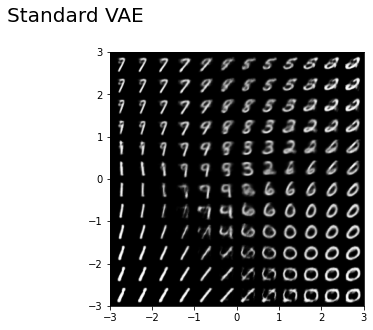

In [39]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Standard VAE", fontsize = 20)
ax1 = fig.add_subplot(1,2,2)
ax1 = plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))